The Enron email and financial data have been combined into a dictionary, where each key-value pair in the dictionary corresponds to one person. The dictionary key is the person's name, and the value is another dictionary, which contains the names of all the features and their values for that person. The features in the data fall into three major types, namely financial features, email features and POI labels.

In [1]:
import sys
import pickle
sys.path.append("/tools/")

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectPercentile
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from time import time
from sklearn.grid_search import GridSearchCV

from IPython.display import display

import warnings

import matplotlib.pyplot as plt
%matplotlib inline

/Users/Sian/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Sian/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    enron_data = pickle.load(data_file)
df = pd.DataFrame.from_dict(enron_data, orient='index')

## Explore the data set
We'll start off by briefly explore the data set to find out what type of values we're dealing with, if there's a lot of missing values etc. 

In [3]:
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [4]:
print 'Number of features:', len(df.columns)
print 'Total number of people:', df['poi'].count()
print 'Number of POIs in data set:', df.loc[df.poi == True, 'poi'].count()

count = 0
with open('poi_names.txt', 'r') as f:
    for line in f:
        if '(y)' in line or '(n)' in line:
            count += 1
print "Number of POI in poi_names.txt:", count

Number of features: 21
Total number of people: 146
Number of POIs in data set: 18
Number of POI in poi_names.txt: 35


There are only 18 POIs are present in this dataset, whereas there are 35 present in the text file that was hand generated. This could be a limiting factor for machine learning as an algorithm will be more robust the more data it has for both training and testing.

In [5]:
# How many people in this dataset have a quantified salary, known email address or NaN payments?
print "The number of quantified salaries is:", (df['salary'] !='NaN').sum()
print "The total number of given email addresses is:", (df['email_address'] !='NaN').sum()
print "The number of NaN payments is:", (df['total_payments'] =='NaN').sum()

The number of quantified salaries is: 95
The total number of given email addresses is: 111
The number of NaN payments is: 21


The NaN's found in the financial data could be interpreted as 0. Looking at the insider pay document we can see that some employees have 0 listed for their bonus. Therefore I will replace the NaNs in the financial data with 0s. 

In [6]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees']
df = df.replace('NaN', np.nan)
df[financial_features] = df[financial_features].fillna(0)

We will also neeed to fill in NaN for email features as well. I will fill in the missing values with the median of the columns.

In [7]:
email_features = ['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']
df[email_features] = df[email_features].fillna(df[email_features].median())

In [8]:
#Check to see NaN values have been replaced.
df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,0.0,2195.0,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,41.0,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,0.0,29.0,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,0.0,41.0,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,0.0,41.0,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0


## Outliers

I'll examine the financial features to see if there are any outliers.

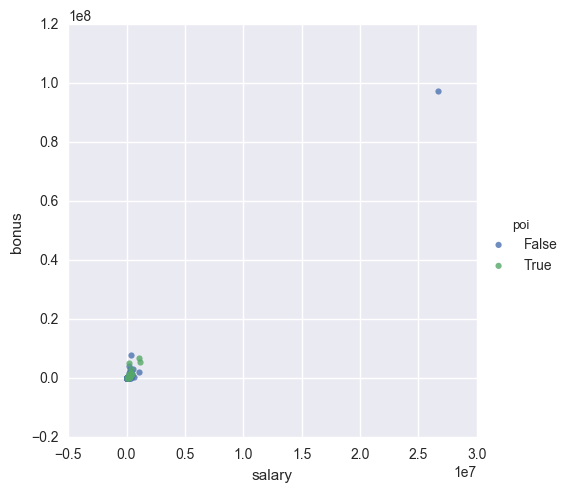

In [9]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False, 
           hue='poi')

There is an obvious outlier in the plot above. After comparing the data point to the salary documents it turns out that this point is the 'TOTAL' value of all the listed salries. Since this doesn't represent anyone in particular it will be manually removed. 

In [10]:
df = df.drop('TOTAL')

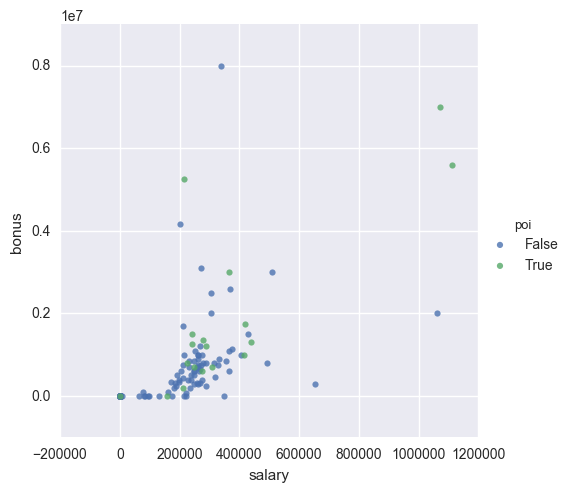

In [11]:
sns.lmplot('salary', 'bonus', 
           data=df, 
           fit_reg=False, 
           hue='poi')

After removing this point it looks like there are still some outliers. These other outliers are people with extremely high salaries/bonuses. Even though they look like outliers they are in fact accurate values, many of which correspond to POIs, so they won't be removed. Furthermore, this graph further highlights how salary and bonus are good indicators for pois. 

##  Creating new features


It's worthwhile looking into the emails variables. The assumption is that people who received/sent a significant amount of emails from/to POI might also have been a POI. Hence, a closer look at the number of emails being sent/received could be helpful in identifying POIs.

Two new features will be created: (i) fracion_msgs_to_poi and (ii) fracion_msgs_from_poi. These are the fractions of messages a person sends/receives to/from a POI. These two features are helpful as they measure the proportion of emails that are related to a POI. Someone who sends/receives a lot of emails to/from a POI is more likely to be a POI themselves.

In [12]:
df_new = df.copy()
df_new['fracion_msgs_to_poi'] = df.from_this_person_to_poi / df.from_messages
df_new['fracion_msgs_from_poi'] = df.from_poi_to_this_person / df.to_messages

In [13]:
df_new.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person,fracion_msgs_to_poi,fracion_msgs_from_poi
ALLEN PHILLIP K,201955.0,2902.0,2869717.0,4484442.0,1729541.0,4175000.0,126027.0,1407.0,-126027.0,1729541.0,...,152.0,65.0,False,0.0,-3081055.0,304805.0,phillip.allen@enron.com,47.0,0.029613,0.016196
BADUM JAMES P,0.0,1211.0,178980.0,182466.0,257817.0,0.0,0.0,740.5,0.0,257817.0,...,0.0,8.0,False,0.0,0.0,0.0,NaN,35.0,0.195122,0.028902
BANNANTINE JAMES M,477.0,566.0,0.0,916197.0,4046157.0,0.0,1757552.0,465.0,-560222.0,5243487.0,...,864523.0,0.0,False,0.0,-5104.0,0.0,james.bannantine@enron.com,39.0,0.000000,0.068905
BAXTER JOHN C,267102.0,1211.0,1295738.0,5634343.0,6680544.0,1200000.0,3942714.0,740.5,0.0,10623258.0,...,2660303.0,8.0,False,0.0,-1386055.0,1586055.0,NaN,35.0,0.195122,0.028902
BAY FRANKLIN R,239671.0,1211.0,260455.0,827696.0,0.0,400000.0,145796.0,740.5,-82782.0,63014.0,...,69.0,8.0,False,0.0,-201641.0,0.0,frank.bay@enron.com,35.0,0.195122,0.028902


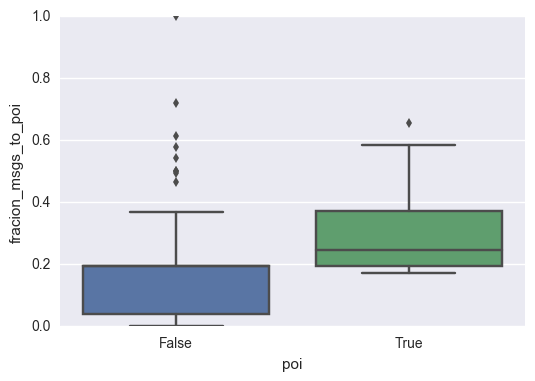

In [14]:
ax = sns.boxplot(x="poi", y="fracion_msgs_to_poi", data=df_new)

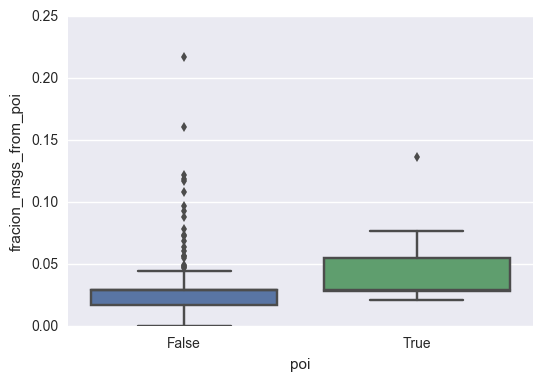

In [15]:
ax = sns.boxplot(x="poi", y="fracion_msgs_from_poi", data=df_new)

Although the box plots show quite a few outliers I have chosen not to remove them as it may end up removing a POI and we already only have a small number of POIs to work with. In both cases, people who are sending/receiving a large proportion of their emails to/from a POI are on average likely to be a POI themselves. This could be a good indicator in identifying POIs, although it is probably not as robust as the financial indicators.

## Classifying the dataset

From analysing the features,it seems that the enail address field will be of no value to our analysis as it is just a string so it can't be used in a quantitative measure. 

Cross validation is a way of measuring the predictive performance of a model. A classic mistake while performing cross validation is overfitting the data. when this occurs a model is trained very well on a set of data but is then not able to make correct predictions in the testing set. 
Although we can measure the performance of our model by running run it on a set of test data we have a rather small amount of data to work with so we can't expect near perfecr predictions from any of the models that we will use. 

We'll split the data set in to a training and testing set. Using StratifiedShuffleSplit returns stratified randomized folds. Since the data set we are dealing with is relatively small and unbalanced, using StratifiedShuffleSplit to randomly split the dataset, and use the whole dataset for both buidling and assessing the model should lead to a more stable evaluation. 

In [16]:
data = df_new.drop(['poi', 'email_address'], axis=1)
X = data.values
y = df.poi

## Scaling

MinMaxScaler can be used to scales features to a range between 0 and 1. For the purpose of this project I haven't used feature scaling as it is best used for algorithms that use distance metrics, e.g. KNN, linear regression, which I will not be using. 

## Feature reduction

The aim of feature reduction is to select the best number of top features or reduce dimension of features.

PCA (Principal Component Analysis) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. 

There are two big univariate feature selection tools in sklearn: SelectPercentile and SelectKBest. The difference being that SelectPercentile selects the X% of features that are most powerful (where X is a parameter) and SelectKBest selects the K features that are most powerful (where K is a parameter). I have chosen to use SelectPercentile in this case but SelectKParameter would have worked equally as well.

In [17]:
# Generate the training and testing data
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train_pca2 = pca.transform(X_train)
    X_test_pca2 = pca.transform(X_test)

    pca = PCA(n_components=5)
    pca.fit(X_train)

    X_train_pca5 = pca.transform(X_train)
    X_test_pca5 = pca.transform(X_test)

    X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train, y_train)
    X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test, y_test)

    X_train_reduce10 = SelectPercentile().fit_transform(X_train, y_train)
    X_test_reduce10 = SelectPercentile().fit_transform(X_test, y_test)

## Testing accuracy of various classifiers

Four algorithms will be tested: AdaBoost, Naive Bayes, Decision tree classifier and Random Forest. For each algorithm, evaluation metrics including accuracy, precision, recall and f1 score will be calculated for a varying number of features from SelectPercentile and PCA methods. 

Accuracy, precision, recall and f1 score are used as metrics to evaluate the model performance. 
* Accuracy: True Positive + True Negative / (True Positive + True Negative + False Positive + False Negative). Accuracy measures the percentage of correctly identified POIs and non-POIs from all of the predictions made. Accuracy is a good initial indicator but it can be misleading.
* Precision: True Positive / (True Positive + False Positive). Precision measures how many of the items labeled as positive truely belong to the positive class. Precision will show out of the cases that are identified as POIs how many are actually POIs.
* Recall:  True Positive / (True Positive + False Negative). Recall measure out of all the items that are truely positive, how many were correctly classified as positive. Recall will show out of the cases that are actually POIs how many were identified as POIs.
* F1 score gives a harmonic mean of precision and recall.


In [18]:
def rate_models(X,y):
    models = {"AdaBoost Classifier": AdaBoostClassifier(), "Gaussian Naive Bayes": GaussianNB(), 
                  "Decision Tree Classifier": tree.DecisionTreeClassifier(), "Random Forest Classifier": RandomForestClassifier()} 


    data = {"": X_train, "(30% of features)": X_train_reduce30, "(10% of features)": X_train_reduce10,
               "(PCA: 2 components)": X_train_pca2, "(PCA: 5 components)": X_train_pca5}

    res = {}

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        for name, model in models.items():
            for scale, X in data.items():
                n = name + " " + scale
                clf = model
                accuracy = cross_val_score(clf, X_train, y_train).mean()

                y_pred = cross_val_predict(clf, X_train, y_train)

                rec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                prec = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()
                f1 = cross_val_score(clf, X_train, y_train, scoring=make_scorer(recall_score)).mean()


                res[n] = {"MeanAccuracy": accuracy, "Precision": prec, "Recall": rec, "F1Score": f1}

    results = pd.DataFrame.from_dict(res, orient="index")
    results = results[["MeanAccuracy", "Precision", "Recall", "F1Score"]]

    display(results)

In [19]:
rate_models(X,y)

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.835000,0.444444,0.444444,0.444444
AdaBoost Classifier (10% of features),0.835000,0.444444,0.444444,0.444444
AdaBoost Classifier (30% of features),0.835000,0.444444,0.444444,0.444444
AdaBoost Classifier (PCA: 2 components),0.835000,0.444444,0.444444,0.444444
AdaBoost Classifier (PCA: 5 components),0.835000,0.444444,0.444444,0.444444
Decision Tree Classifier,0.848889,0.444444,0.666667,0.666667
Decision Tree Classifier (10% of features),0.835000,0.555556,0.444444,0.666667
Decision Tree Classifier (30% of features),0.835000,0.444444,0.666667,0.666667
Decision Tree Classifier (PCA: 2 components),0.835000,0.666667,0.444444,0.444444
Decision Tree Classifier (PCA: 5 components),0.848889,0.666667,0.666667,0.666667


When using the newly generated features we obtain the best results using a Gaussian Naive Bayes algorithm which leads to precision, recall and F1 score of 77.8%. The second best classifier in this case is the Decisio Tree classifier.

### Let's do the same for the data set that doesn't contain the newly generated features:

In [20]:
data = df.drop(['poi', 'email_address'], axis=1)
X = data.values
y = df.poi

In [21]:
skf = StratifiedKFold(n_splits=2)
skf.get_n_splits(X, y)

StratifiedKFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    pca = PCA(n_components=2)
    pca.fit(X_train)

    X_train_pca2 = pca.transform(X_train)
    X_test_pca2 = pca.transform(X_test)

    pca = PCA(n_components=5)
    pca.fit(X_train)

    X_train_pca5 = pca.transform(X_train)
    X_test_pca5 = pca.transform(X_test)

    X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train, y_train)
    X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test, y_test)

    X_train_reduce10 = SelectPercentile().fit_transform(X_train, y_train)
    X_test_reduce10 = SelectPercentile().fit_transform(X_test, y_test)

In [22]:
rate_models(X,y)

,MeanAccuracy,Precision,Recall,F1Score
AdaBoost Classifier,0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (10% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (30% of features),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (PCA: 2 components),0.779444,0.222222,0.222222,0.222222
AdaBoost Classifier (PCA: 5 components),0.779444,0.222222,0.222222,0.222222
Decision Tree Classifier,0.835000,0.444444,0.666667,0.444444
Decision Tree Classifier (10% of features),0.848889,0.666667,0.666667,0.666667
Decision Tree Classifier (30% of features),0.848889,0.444444,0.444444,0.444444
Decision Tree Classifier (PCA: 2 components),0.848889,0.666667,0.666667,0.666667
Decision Tree Classifier (PCA: 5 components),0.848889,0.555556,0.444444,0.444444


A quick note on accuracy: as shown above, accuracy can be a misleading metric. Take a look at the Random Forest Classifier without any parameter tuning. It has a relatively high accuracy score of 0.835, but it scored a 0 in recall and 0.11 in precision. I think that the unbalanced classes could be contributing to the underwhelming initial performance, so parameter tuning will take on an added performance here.

Once again our best performing classifier in terms of recall and precision was the Gaussian Naive Bayes classifier. With a recall of 77%, this classifier correctly flagged more than half of the POIs in our data. That classifier also had the highest F1 score (the harmonic mean of precision and recall).

Now let's do some parameter tuning, in the hopes that we might be able to bring up the recall of some our next best performing algorithm in a meaningful way.

## Comparing results of old data set to new (that includes engineered features)

Below is a table showing the best F1 scores acheived for each algorithm when using both the old and new dataset:

|       | New featres used |Precision | Recall  |F1 score  |
| ------------- |:-------------:|:-------------:| -----:|-----:|
| Adaboost     | No | 0.22 |0.22  | 0.22 |
| Decision Tree |No | 0.667 | 0.44  | 0.667 |  
| Naive Bayes | No |0.778 | 0.778  | 0.778  |
| Random Forest | No |  0.11  | 0.11 | 0.33 |
| Adaboost     | Yes | 0.44 | 0.44 | 0.44  |
| Decision Tree | Yes | 0.667|  0.44  | 0.556  |  
| Naive Bayes | Yes | 0.778 | 0.778  | 0.778  |
| Random Forest | Yes | 0.22 | 0 | 0.22 |



The new features don't appear to have had any affect on Naive Bayes and the Decision tree algorithms. However, it has improved the Adaboost and had a worse effect on Random Forest F1 scores but a greater precision. 

For our two best performing algorithms - Naive Bayes and Decision Tree we seem to get the best results when we don't include the newly generated features so I will proceed with the old data set.

## Parameter tuning

The top performer, GaussianNB, doesn't actually have any parameters to tune. Let's focus on another classifier instead. Our next best classifier in terms of the F1 score was the Decision Tree Classifier. 

We will be tuning:
* The minimum number of samples required to be at a leaf node
* The maximum depth of the tree

Parameter tuning searches for optimized parameters for a given algorithm. It is an important step because even if a well suited algorithm is used without the correct parameters it can perform poorly. In order to acheive the best possible results we can use GridSerchCV to search for the best parameters to use for a given algorithm. GridSearch is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.

In [23]:
parameters = {
    'criterion': ('gini', 'entropy'),
    'min_samples_leaf':range(1, 50, 5),
    'max_depth': range(1, 10)
}

scorer = make_scorer(f1_score)

DTC = DecisionTreeClassifier(random_state=42)

clf = GridSearchCV(DTC, param_grid=parameters, scoring=scorer)

clf.fit(X_train_pca5, y_train)

clf.best_params_, clf.best_score_ 

/Users/Sian/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


({'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 6},
 0.5469667318982387)

## Evaluation metrics

Let's use our fit and tuned Decision Tree classifier to make some POI predictions on our test data. 

In [25]:
clf = DecisionTreeClassifier(splitter="random",
                             max_depth=4,
                             criterion='entropy',
                             min_samples_split=10,
                             max_leaf_nodes=6,
                             class_weight="balanced",
                             random_state=42)

clf.fit(X_train_pca5,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
            max_depth=4, max_features=None, max_leaf_nodes=6,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random')

Testing the final algorithm and parameters with the tester.py led to:
* Accuracy: 73.8% 
* Recall: 85.2% 
* Precision: 32%
* F1 score: 46%

So it definitely isn't perfect, but we didn't expect it to be given the precison and recall rates. It would not be good enough to risk prosecuting a person on given it incorrectly identifoed some POIs and missed some true POIs. 